# Matrix Factorisation - Linear with Bias

In [28]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [29]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [30]:
%matplotlib inline

## Prepare the data

In [31]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [32]:
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [33]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [34]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [35]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(np.int64(1), np.int64(5))

In [36]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [37]:
train, test = user_split(DATA, "timestamp", "user_id", [0.9, 0.1])

In [38]:
train.shape, test.shape

((90009, 7), (9991, 7))

# Explicit Matrix Factorisation

In [39]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils import model_to_dot
from reco import vis

In [40]:
def Explicit_MF_Bias(n_users, n_items, n_factors, min_rating=1, max_rating=5):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-5), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    
    return model

In [41]:
n_factors = 50
model = Explicit_MF_Bias(n_users, n_items, n_factors)

In [42]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemEmbedding       │ (None, 1, 50)     │     84,100 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserEmbedding       │ (None, 1, 50)     │     47,150 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemE        │ (None, 50)        │          0 │ ItemEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUserE        │ (None, 50)        │          0 │ UserEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemBias            │ (None, 1, 1)      │      1,682 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserBias            │ (None, 1, 1)      │        943 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DotProduct (Dot)    │ (None, 1)         │          0 │ FlattenItemE[0][… │
│                     │                   │            │ FlattenUserE[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemBiasE    │ (None, 1)         │          0 │ ItemBias[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUserBiasE    │ (None, 1)         │          0 │ UserBias[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AddBias (Add)       │ (None, 1)         │          0 │ DotProduct[0][0], │
│                     │                   │            │ FlattenItemBiasE… │
│                     │                   │            │ FlattenUserBiasE… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ AddBias[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ activation_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,875 (522.95 KB)

 Trainable params: 133,875 (522.95 KB)

 Non-trainable params: 0 (0.00 B)

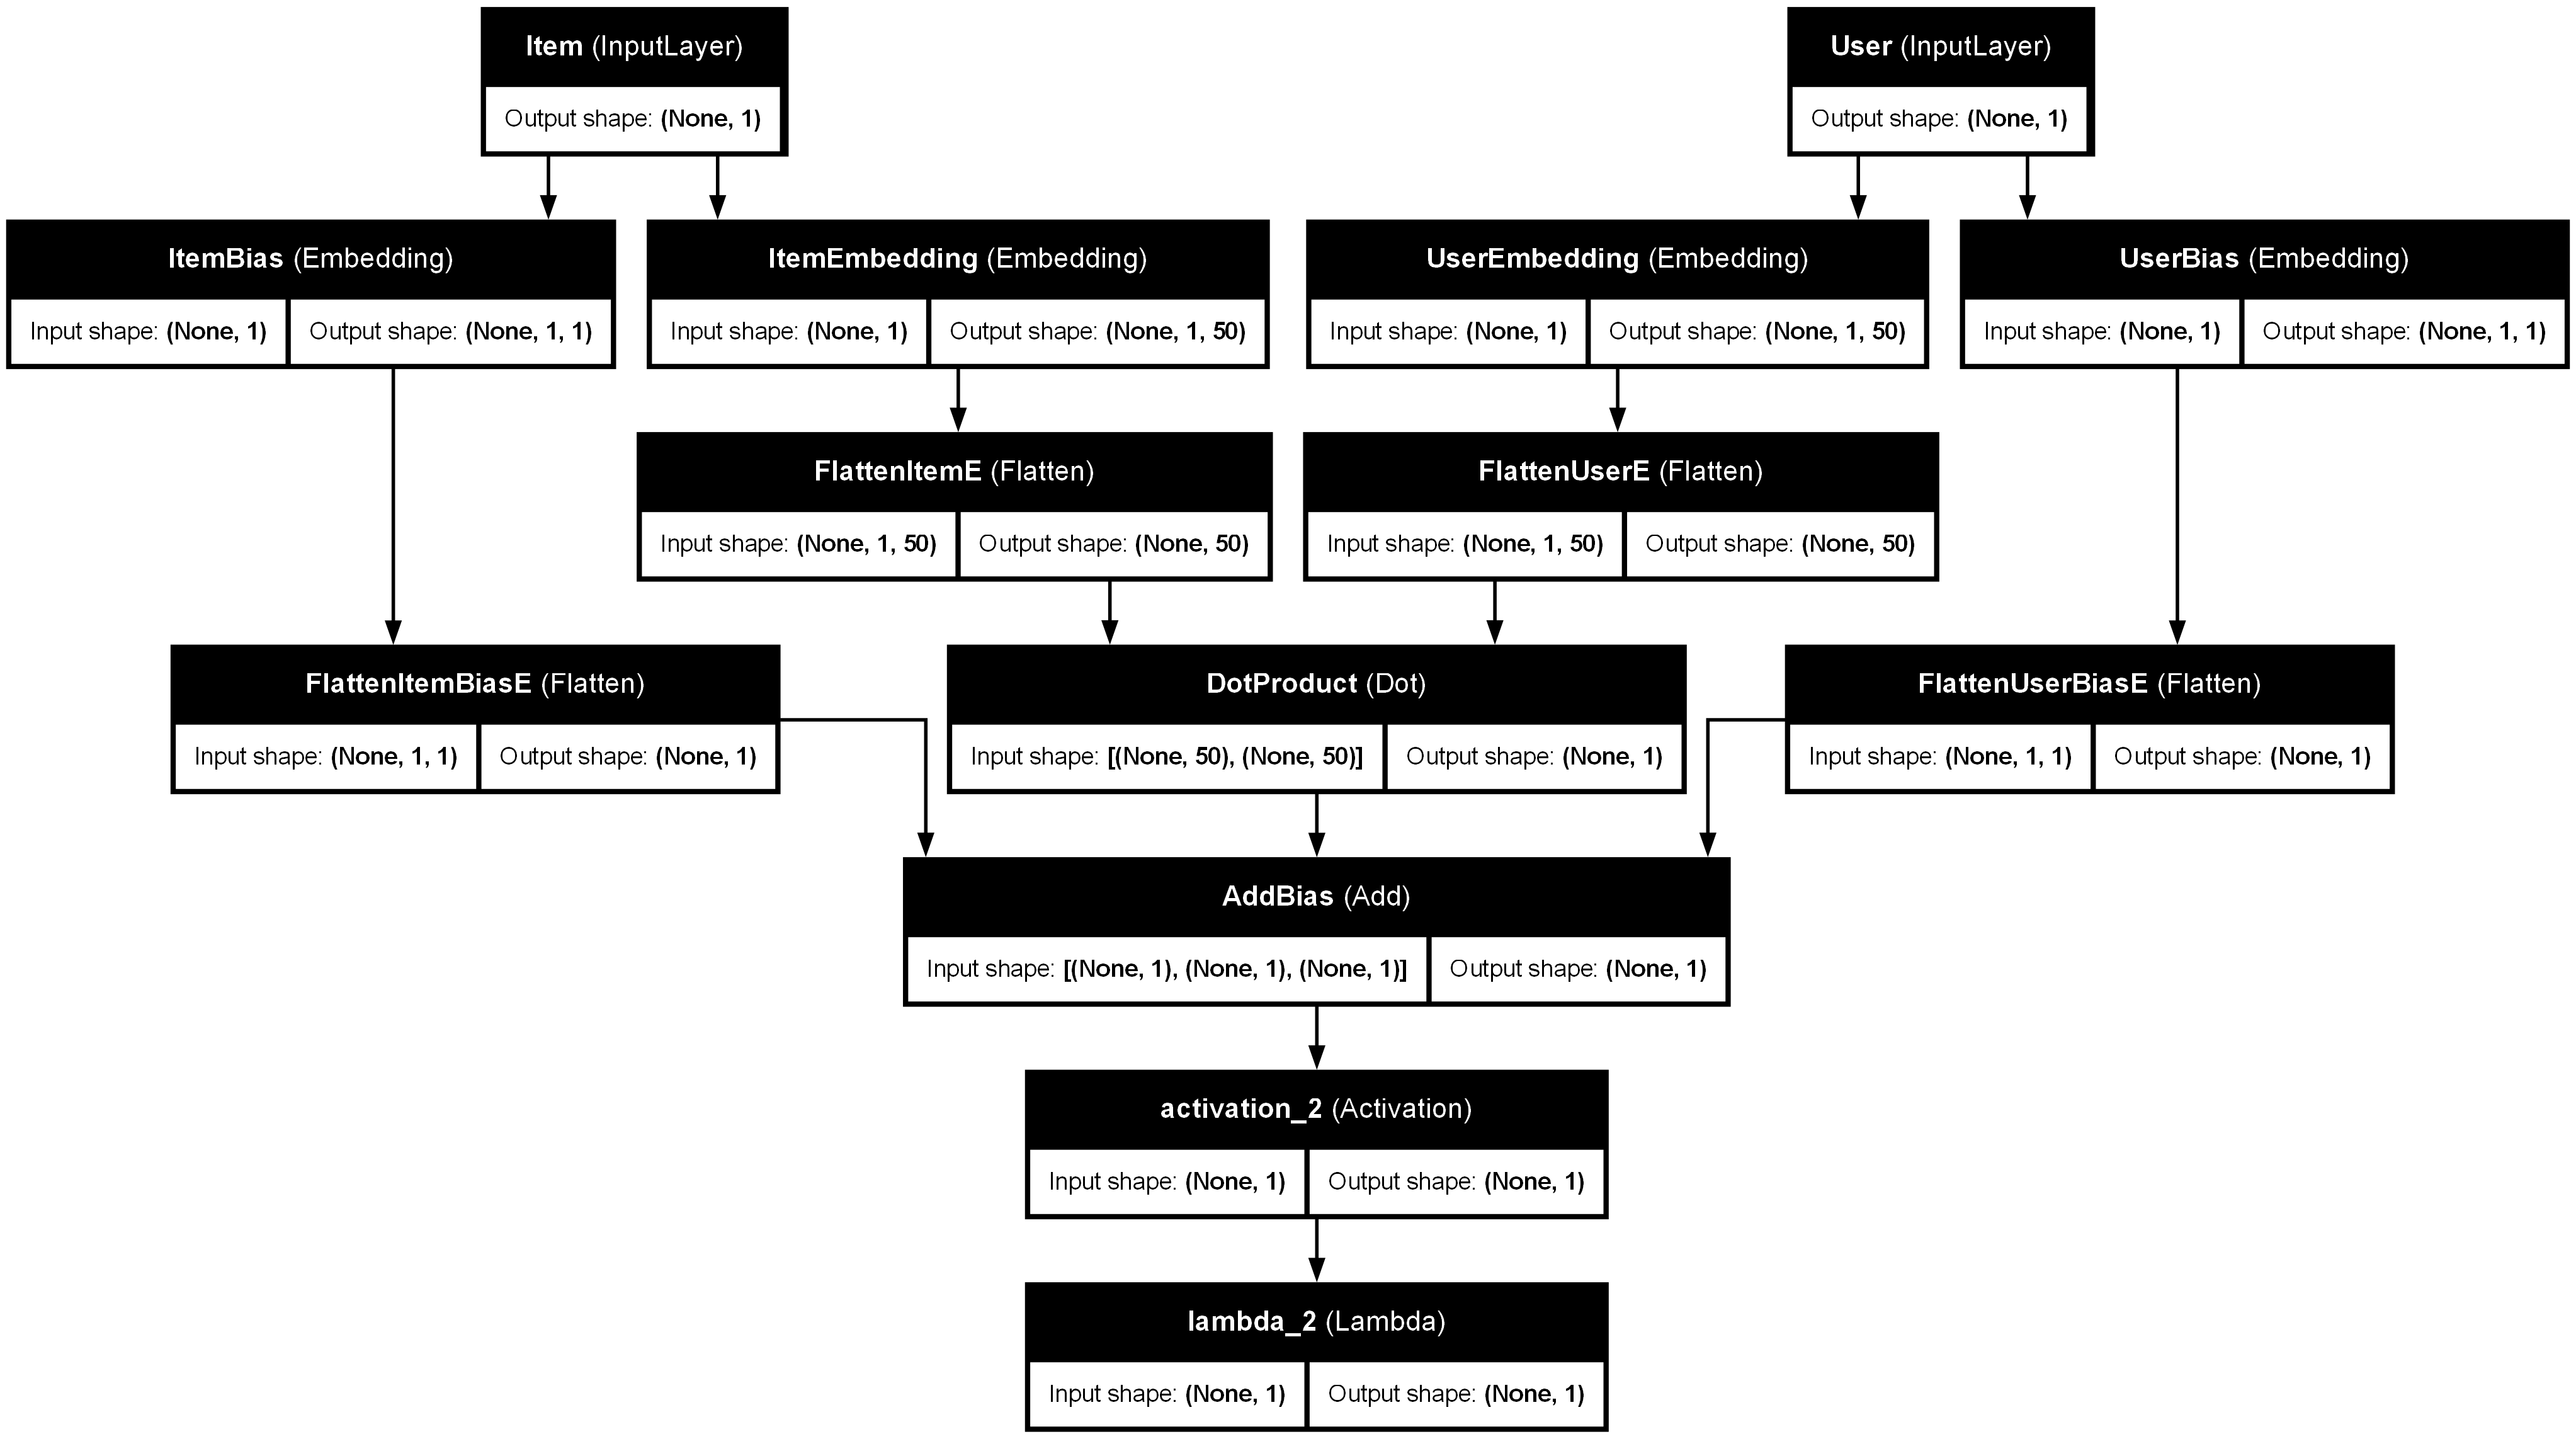

In [43]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/explicit-mf-bias.png" )

## Train the model

In [44]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=32, epochs=3, verbose=1, 
                   validation_data=([test.USER, test.ITEM], test.RATING))

Epoch 1/3
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.3311 - val_loss: 0.9254
Epoch 2/3
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.8395 - val_loss: 0.8487
Epoch 3/3
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7061 - val_loss: 0.8347
CPU times: total: 32.1 s
Wall time: 12.7 s


In [45]:
vis.metrics(output.history)

alt.FacetChart(...)

## Score the model

In [46]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.8583


0.8347498178482056

## Evaluate the model

In [47]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [48]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [49]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 30s 611us/step
CPU times: total: 59.9 s
Wall time: 43.6 s


In [50]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,3.779903
1,195,301,3.954379
2,195,376,2.487937
3,195,50,3.350652
4,195,345,3.537950


In [51]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 33s 665us/step
CPU times: total: 1min 2s
Wall time: 46.6 s


In [52]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.061516
Precision@K:	0.039555
Recall@K:	0.039090


## Get similar items

In [53]:
from reco.recommend import get_similar, show_similar

In [54]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: total: 125 ms
Wall time: 116 ms


In [55]:
item_similar_indices

array([[   0,  209,  968,  114,  420],
       [   1,  785, 1388, 1619, 1409],
       [   2, 1467,  993, 1165,  577],
       ...,
       [1679, 1677, 1675, 1617, 1623],
       [1680, 1626, 1514, 1524, 1676],
       [1681, 1432, 1155, 1637, 1121]])

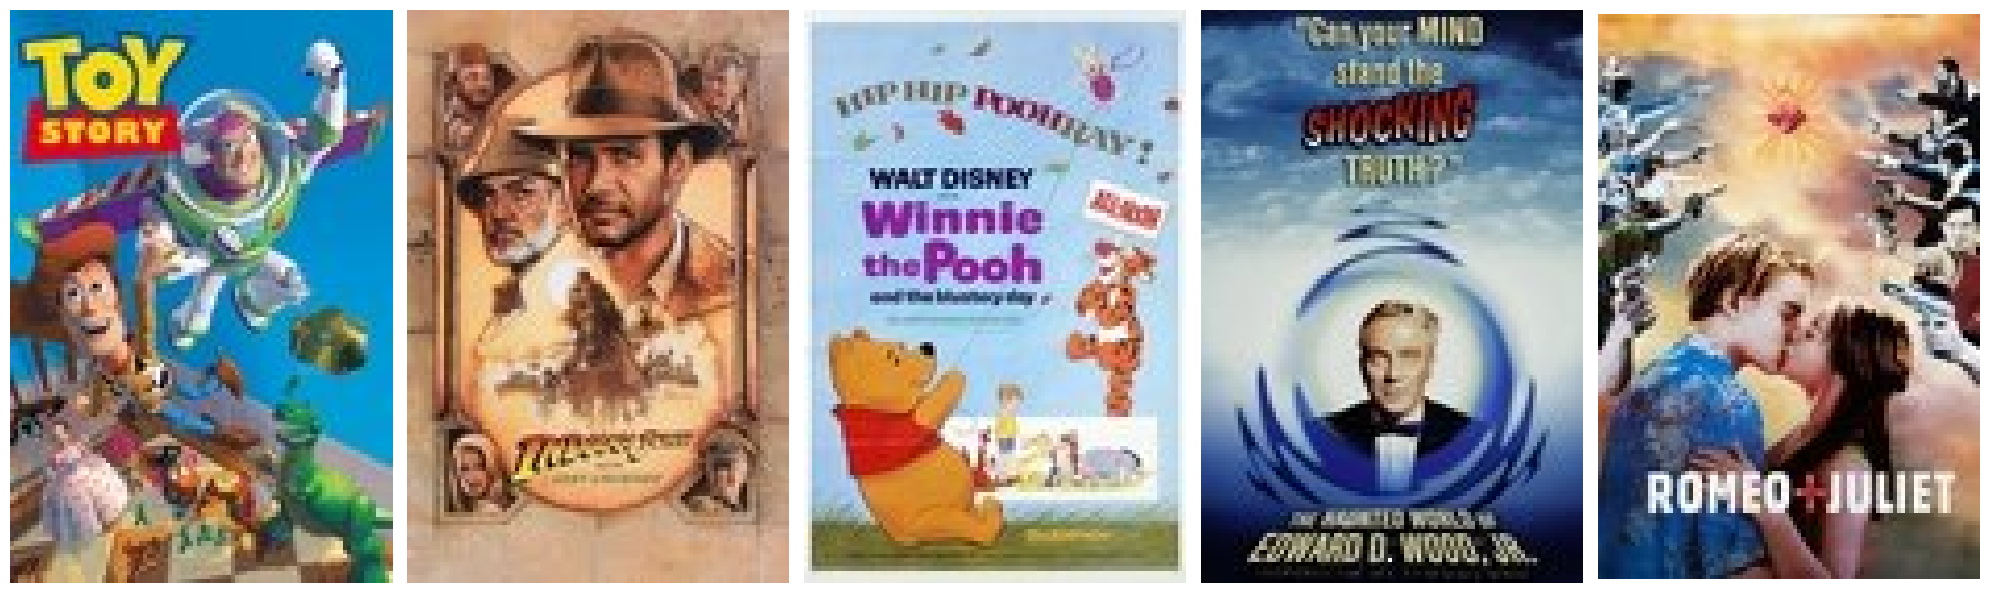

In [56]:
show_similar(0, item_similar_indices, item_encoder)